# Logística de envíos: ¿Cuándo llega?

## Mentoría DiploDatos 2019 

### Integrantes:

- Chaves, Noelia
- Frau, Johanna

### Mentora:

- Dal Lago, Virginia

### Práctico: Introducción al aprendizaje automático

## Motivación

En la actualidad, cada vez más productos se comercializan a través de una plataforma online. Una de las principales ventajas de este sistema es que el usuario puede recibir el producto en su domicilio en una fecha determinada. Pero, ¿cómo sabemos qué día va a llegar? ¿A partir de qué datos podemos predecir la demora del envío? En este práctico se trabajará con datos de envíos de MercadoLibre, el e-commerce más grande de Latinoamérica, analizando y modelando el problema de logística de envíos para poder responder ¿cuándo llega?

## Descripción del dataset

**Datos:**  El conjunto de datos seleccionado para realizar el práctico corresponde a un muestreo aleatorio no uniforme de 500.000 envíos de MercadoLibre. Estos envíos fueron realizados en Brasil en el período comprendido entre Octubre de 2018 y Abril de 2019 (las fechas originales han sido modificadas y adaptadas a un período de tiempo diferente, conservando el día de la semana y considerando los feriados correspondientes). Mientras que las fechas han sido modificadas, los horarios registrados en el dataset son los originales. Los datos comprenden variables tanto categóricas como numéricas. 

El dataset cuenta con las siguientes columnas:

- **Sender_state:** Estado de Brasil de donde sale el envío.
- **Sender_zipcode:** Código postal (de 5 dígitos) de donde sale el envío.
- **Receiver_state:** Estado de Brasil a donde llega el envío.
- **Receiver_zipcode:** Código postal (de 5 dígitos) a donde llega el envío.
- **Shipment_type:** Método de envío (normal, express, super).
- **Quantity:** Cantidad de productos en un envío.
- **Service:** Servicio del correo con el cual se realizó un envío.
- **Status:** Estado del envío (set: listo para ser enviado, sent: enviado, done: entregado, failed: no entregado, cancelled: cancelado).
- **Date_created:** Fecha de creación del envío.
- **Date_sent:** Fecha y hora en que se realizó el envío (salió del correo).
- **Date_visit:** Fecha y hora en que se entregó el envío al destinatario.
- **Shipment_days:** Días hábiles entre que el envío fue enviado (salió del correo) y que fue entregado.




## Objetivos generales

  * Realizar de manera completa el proceso de desarrollo de un modelo de aprendizaje automático para determinar cuándo llega un envío.
  * Desarrollar el conocimiento práctico sobre dicho proceso, desde la definición de los datasets, la elección y análisis del modelo y las métricas propias para la problemática.
  * Desarrollar habilidades de comunicación de la información obtenida a partir de los datos de manera clara y sencilla.

## Objetivos específicos

* Probar diferentes modelos de aprendizaje automático ver cual se comporta mejor con nuestro dataset.
* Hacer una partición de los datos que tenga sentido en nuestra problemática.
* Seguir analizando cuáles features resultan más importantes en la predicción a realizar.

## Desarrollo del trabajo

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
import seaborn as sns


from datetime import timedelta
from IPython.display import HTML
from matplotlib.colors import ListedColormap
from scipy import stats
from sklearn import preprocessing
from sklearn import tree
from sklearn.linear_model import LinearRegression, SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures

### Lectura y análisis inicial de los datos

In [0]:
url = "https://raw.githubusercontent.com/cnoeliachaves/csv/master/dataset_sample_corrected.csv"

dataset = pandas.read_csv(url, dtype={'sender_zipcode':'int64',
                              'receiver_zipcode':'int64',
                              'quantity':'int64',
                              'service':'int64'},
                       parse_dates=['date_created','date_sent','date_visit'])
dataset.shape


(500000, 12)

In [0]:
dataset.columns

Index(['sender_state', 'sender_zipcode', 'receiver_state', 'receiver_zipcode',
       'shipment_type', 'quantity', 'service', 'status', 'date_created',
       'date_sent', 'date_visit', 'shipment_days'],
      dtype='object')

In [0]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 12 columns):
sender_state        500000 non-null object
sender_zipcode      500000 non-null int64
receiver_state      500000 non-null object
receiver_zipcode    500000 non-null int64
shipment_type       500000 non-null object
quantity            500000 non-null int64
service             500000 non-null int64
status              500000 non-null object
date_created        500000 non-null datetime64[ns]
date_sent           499971 non-null datetime64[ns]
date_visit          499398 non-null datetime64[ns]
shipment_days       499398 non-null float64
dtypes: datetime64[ns](3), float64(1), int64(4), object(4)
memory usage: 45.8+ MB


In [0]:
np.random.seed(1234) #con propositos de reproducibilidad
dataset.sample(10)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
459222,SP,4691,PA,68330,standard,1,1,done,2019-02-02,2019-02-05 07:12:00,2019-03-11 16:04:00,21.0
28619,SP,3017,RS,98130,standard,1,1,done,2019-02-11,2019-02-18 16:17:00,2019-03-14 06:32:00,15.0
453020,SP,14405,MG,37130,standard,1,2,done,2019-03-05,2019-03-09 04:44:28,2019-03-13 16:07:00,2.0
16289,SP,4904,SP,15500,express,1,3,done,2019-03-12,2019-03-14 15:09:00,2019-03-20 18:05:00,4.0
337995,SP,4266,MA,65061,standard,1,4,done,2019-03-13,2019-03-15 01:18:29,2019-03-25 11:17:00,6.0
232178,SP,13290,SP,6050,super,1,6,done,2019-02-28,2019-03-01 02:25:00,2019-03-07 11:20:37,1.0
220911,SP,6311,SP,11520,express,1,0,done,2019-03-04,2019-03-06 15:36:00,2019-03-08 18:59:00,1.0
33028,SP,7803,SP,13503,express,1,0,done,2019-03-08,2019-03-08 17:05:00,2019-03-12 16:01:00,2.0
35358,SP,1536,PE,56828,standard,1,1,done,2019-03-03,2019-03-05 11:22:46,2019-03-19 13:18:00,8.0
47950,SP,12322,ES,29680,standard,2,1,done,2019-03-05,2019-03-06 10:34:00,2019-03-18 15:06:00,7.0


### Limpieza de datos

En esta sección retomaremos algunos puntos del práctico anterior con el objetivo de limpiar nuestro dataset.

#### Shipment day anómalos 

En primer lugar, eliminaremos los valores de shipment days negativos.

In [0]:
def clean_shipment_days(dataset):
    """Le saco los valores negativos"""
    shipments_days = dataset['shipment_days']
    mask = (shipments_days >= 0)
    return dataset[mask] 

In [0]:
dataset_clean = clean_shipment_days(dataset)

####Fechas anómalas

En el análisis realizado en el práctico anterior de las 3 variables con información de fechas y horas encontramos que la variable date_created cuenta con valores que caen fuera del intervalo temporal considerado y que todos ellos se encuentran ubicados en el mes de Junio de 2019. Luego de haber realizado una inspección de esta información anómala llegamos a la conclusión que los mismos podrían deberse a un error en el proceso de carga y que en realidad son datos de Enero de 2019. 

Siguiendo esta idea decidimos en este momento subsanar este posible error de carga haciendo que la información de la variable date_created correspondiente al mes de Junio de 2019 sea ahora del mes de Enero de 2019.

In [0]:
date_created_junio = dataset_clean[dataset_clean['date_created'].map(lambda x: x.month) == 6]
date_created_junio

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
14265,SP,2350,RJ,20261,express,1,7,done,2019-06-27,2019-02-06 05:57:00,2019-03-01 11:31:00,17.0
18211,SP,7756,SP,13214,express,1,7,done,2019-06-27,2019-02-06 05:00:00,2019-03-01 09:08:00,17.0
27700,SP,5034,GO,74565,standard,1,7,done,2019-06-26,2019-02-06 10:56:00,2019-03-01 11:54:00,17.0
28540,SP,9060,MA,65050,standard,1,4,done,2019-06-20,2019-02-06 10:00:00,2019-03-01 12:02:00,17.0
33158,SP,16204,MG,31910,standard,2,7,done,2019-06-27,2019-02-06 04:03:00,2019-03-01 16:43:00,17.0
38127,SP,2460,SP,13335,express,1,7,done,2019-06-26,2019-03-06 01:18:00,2019-03-07 14:03:00,0.0
42758,SP,1042,SP,11070,express,1,4,done,2019-06-25,2019-02-06 05:01:00,2019-03-01 16:09:00,17.0
43607,SP,6422,RS,91750,standard,1,7,done,2019-06-19,2019-02-06 04:41:00,2019-03-01 14:30:00,17.0
45731,SP,14405,ES,29164,standard,1,7,done,2019-06-22,2019-03-06 03:02:00,2019-03-07 04:27:00,0.0
58502,SP,12950,ES,29800,standard,1,7,done,2019-06-25,2019-02-06 04:42:00,2019-03-01 07:29:00,17.0


In [0]:
date_created_junio = dataset_clean['date_created'].map(lambda x: 
                                                       x+timedelta(days=-151) 
                                                       if x.month==6 else x) 


In [0]:
dataset_clean.loc[:,'date_created'] = date_created_junio

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [0]:
dataset_clean['date_created'].dt.month.unique()

array([ 3,  2,  1,  4, 12, 10, 11])

In [0]:
dataset_clean.describe(include='datetime64')

,date_created,date_sent,date_visit
count,499350,499350,499350
unique,124,81276,55668
top,2019-03-05 00:00:00,2019-03-11 15:53:00,2019-03-11 22:00:00
freq,20424,113,621
first,2018-10-21 00:00:00,2018-10-23 13:57:00,2019-02-25 05:36:00
last,2019-04-29 00:00:00,2019-03-29 01:46:20,2019-04-02 15:35:00


En el describe de arriba, podemos ver que la última fecha de creación es posterior a la última fecha de data_sent como date_visit, pero consideramos que dichos datos son correctos, ya que no contamos con el completo dataset.

#### Valores nulos

Veamos cuantos valores nulos tenemos

In [0]:
null_values_count = dataset_clean.isnull().sum()
null_values_count[null_values_count > 0]

Series([], dtype: int64)

Podemos ver que no tenemos valores nulos en el dataset.

#### Limpieza de las fechas anomálas

Ahora limpiaremos el dataset sacando todas aquellas fechas que no se siguen en la línea temporal. 

In [0]:
date_created_before_date_sent = dataset_clean.date_created < dataset_clean.date_sent #Filtramos date_created menores que date_sent

date_sent_before_date_visit = dataset_clean.date_sent < dataset_clean.date_visit #Filtramos date_sent menores que date_visit

date_created_before_date_visit = dataset_clean.date_created < dataset_clean.date_visit #Filtramos date_created menores que date_visit


In [0]:
dataset_clean = dataset_clean[date_created_before_date_sent].dropna() # solo fechas de creacion antes de la fecha de envio
dataset_clean = dataset_clean[date_created_before_date_visit].dropna()# solo fechas de creacion antes de la fecha de visita
dataset_clean = dataset_clean[date_sent_before_date_visit].dropna()# solo fechas de envios antes de la fecha de visita
dataset_clean.sample(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
61209,SP,9520,BA,46940,standard,1,1,done,2019-03-15,2019-03-19 13:17:00,2019-03-27 15:24:00,6.0
72136,SP,9510,MG,35500,standard,1,1,done,2019-02-24,2019-02-25 18:59:00,2019-03-15 08:59:00,11.0
192050,SP,9635,PR,87033,standard,1,1,done,2019-03-18,2019-03-19 08:12:00,2019-03-28 15:29:00,7.0
287022,SP,8586,DF,70384,standard,1,4,done,2019-03-08,2019-03-12 07:26:55,2019-03-14 06:12:00,2.0
467512,SP,2180,GO,74255,express,1,3,done,2019-03-21,2019-03-24 04:57:00,2019-03-29 22:00:00,4.0


### La importancia de predecir el valor de la variable shipment_days

Uno de los objetivos principales del análisis propuesto en esta mentoría es predecir (dar un número aproximado de días hábiles) el tiempo entre que se despacha del correo hasta que el mismo llega a la casa del comprador. 

Es decir, queremos predecir el feature shipment_days.

Por lo tanto este sería el target de un algoritmo de aprendizaje automático. Si bien este feature originalmente es información de tipo numérica en el práctico anterior utilizamos enconding para convertirla en una variable categórica. Así, esto nos da la posibilidad de trabajar con diferentes modelos de aprendizaje automático utilizando el mismo feature como target pero en sus diferentes versiones.

Frente a este problema consideramos que el estado de Brasil que recibe el envío (receiver_state) es un feature importante a tener en cuenta (mientras más lejos esté de San Pablo probablemente demore más) y probablemente también el código postal de dicho estado (receiver_zipcode). Por otro lado, el tipo de correo (service) también puede ser una variable importante a tener en cuenta porque la calidad de servicio impactará directamente en los días que tarda en llegar el pedido.



In [0]:
dataset_clean.sample(5)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
17790,SP,13880,SP,9060,express,1,0,done,2019-02-28,2019-02-28 13:32:00,2019-03-01 14:25:00,1.0
63099,SP,3508,MS,79140,express,1,0,done,2019-02-27,2019-03-01 15:23:00,2019-03-08 14:58:00,2.0
461551,SP,2120,SP,4836,express,1,0,done,2019-02-19,2019-02-20 11:57:00,2019-03-08 09:32:00,9.0
481950,SP,14161,BA,45830,standard,1,2,done,2019-02-26,2019-02-27 22:54:01,2019-03-25 18:48:00,15.0
126304,SP,1026,MG,37564,standard,1,1,done,2019-02-19,2019-02-25 17:52:00,2019-03-07 13:14:00,5.0


In [0]:
dataset_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496954 entries, 0 to 499999
Data columns (total 12 columns):
sender_state        496954 non-null object
sender_zipcode      496954 non-null int64
receiver_state      496954 non-null object
receiver_zipcode    496954 non-null int64
shipment_type       496954 non-null object
quantity            496954 non-null int64
service             496954 non-null int64
status              496954 non-null object
date_created        496954 non-null datetime64[ns]
date_sent           496954 non-null datetime64[ns]
date_visit          496954 non-null datetime64[ns]
shipment_days       496954 non-null float64
dtypes: datetime64[ns](3), float64(1), int64(4), object(4)
memory usage: 49.3+ MB


Luego de haber limpiado nuestro dataset observamos que contamos con 496954 filas con información, es decir la limpieza solo afectó aproximadamente al 1% de los datos originales.



### Separación en el conjunto de entrenamiento y evaluación 

A continuación analizamos las variables de fechas para poder hacer la separación de los datos. 

In [0]:
# creamos una nueva columna donde date_created solo considera las fechas
dataset_clean['date_created_only_date'] = dataset_clean['date_created'].dt.date

In [0]:
# creamos una nueva columna donde date_visit solo considera las fechas
dataset_clean['date_visit_only_date'] = dataset_clean['date_visit'].dt.date 

In [0]:
dataset_clean.sort_values(by=['date_visit_only_date']) 

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days,date_created_only_date,date_visit_only_date
29645,SP,9550,ES,29170,standard,3,1,done,2019-01-22,2019-01-28 07:20:00,2019-02-25 15:29:00,20.0,2019-01-22,2019-02-25
23725,SP,15410,RJ,28633,standard,1,1,done,2019-02-02,2019-02-05 12:29:00,2019-02-25 15:20:00,14.0,2019-02-02,2019-02-25
327308,SP,3401,MG,37420,standard,1,1,done,2019-02-05,2019-02-06 15:36:00,2019-02-25 09:58:00,13.0,2019-02-05,2019-02-25
87974,SP,1536,PE,54240,standard,1,4,done,2019-01-29,2019-02-03 07:58:02,2019-02-25 14:28:00,15.0,2019-01-29,2019-02-25
192809,SP,1212,SC,88356,standard,1,1,done,2019-01-22,2019-01-23 11:30:00,2019-02-25 12:44:00,22.0,2019-01-22,2019-02-25
327232,SP,18010,SP,15999,standard,1,2,done,2019-02-04,2019-02-06 10:33:32,2019-02-25 16:51:00,13.0,2019-02-04,2019-02-25
242423,SP,4042,RS,96202,standard,1,1,done,2019-01-27,2019-01-30 07:53:00,2019-02-25 16:15:00,18.0,2019-01-27,2019-02-25
175175,SP,14401,BA,42805,standard,1,1,done,2019-02-05,2019-02-06 16:18:00,2019-02-25 15:34:00,13.0,2019-02-05,2019-02-25
327159,SP,9910,RS,96222,standard,1,1,done,2019-02-06,2019-02-08 13:44:00,2019-02-25 16:04:00,11.0,2019-02-06,2019-02-25
129496,SP,7077,ES,29645,standard,1,1,done,2019-02-08,2019-02-08 14:20:00,2019-02-25 11:44:00,11.0,2019-02-08,2019-02-25


Según podemos observar en los cálculos de arriba la variable date_visit  abarca desde el 25-02-2019 al 02-04-2019.

Veamos ahora como se distribuyen estos datos dentro de este intervalo temporal.

In [0]:
dataset_clean['date_visit'].groupby(
                          [dataset_clean['date_visit'].dt.month.rename('month'), 
                           dataset_clean['date_visit'].dt.day.rename('day')]
                           ).agg({'count'})

count
month day       
2     25    2021
      26    1617
      27    2661
      28   21658
3     1    20906
      7    31894
      8    38442
      11   35573
      12   36365
      13   25702
      14   25169
      15   24035
      18   31013
      19   24466
      20   25683
      21   23490
      22   22772
      25   28824
      26   23528
      27   24537
      28   22123
      29    3119
4     1     1309
      2       47

In [0]:
dataset_clean['date_visit'].groupby([dataset_clean['date_visit'].dt.month.rename('month')]).agg({'count'})

,count
month,
2,27957
3,467641
4,1356


Dada la característica de nuestro problema (estimar una cantidad de días) y al estar trabajando con variables de tipo fecha debemos ser cuidadosas al momento de elegir nuestro conjunto de entrenamiento y validación de manera que le den sentido al problema y que al mismo tiempo representen el 70% y 30% respectivamente de los datos. Es decir, la partición debe estar basada en el hecho de que date_created, date_sent y date_visit se siguen una a la otra en la línea temporal. Por lo tanto, los datos a entrenar deben elegirse hasta un cierto día de la variable date_visit y validarse con datos de date_created a partir de esa fecha.

Considerando que nuestro dataset cuenta en este momento con 496954 entradas, el 70% del mismo representa aproximadamente 345000 entradas. Así, de acuerdo a la distribución mostrada arriba si entrenamos nuestro modelo con datos de la variable date_visit hasta el 20 de marzo podriamos llegar a cubrir este porcentaje. En resumen vamos a entrenar con datos que llegaron a destino (este es el por qué se mira data_visit) y vamos a validar con datos cuyas compras se crearon (date_created) después de esa fecha.

A continuación se realizan los cálculos que permitirán hacer la partición de los datos de acuerdo al criterio antes mencionado.

Mask1 la vamos a usar para hacer el filtrado de los datos para el entrenamiento y mask2 la vamos a usar para hacer el filtrado de los datos para la validacion.

In [0]:
mask1 = dataset_clean['date_visit']<=pandas.to_datetime('2019-03-20')
mask2 = dataset_clean['date_created']>pandas.to_datetime('2019-03-20') 

Eliminamos los valores que cumplen con las dos condiciones simultáneamente.

In [0]:
dataset_clean.drop(dataset_clean[mask1&mask2].index, inplace = True)

In [0]:
df_train = dataset_clean.loc[mask1]

In [0]:
df_test = dataset_clean.loc[mask2]

#### Análisis del conjunto de entrenamiento

Veamos a continuación algunos estadísticos y un pequeño análisis de los mismos.

In [0]:
df_train.describe()

,sender_zipcode,receiver_zipcode,quantity,service,shipment_days
count,321523.000000,321523.000000,321523.000000,321523.000000,321523.000000
mean,8255.479456,39516.638433,1.277109,1.490441,4.869235
std,5078.089576,30968.643243,0.660331,1.870620,4.533859
min,1001.000000,1001.000000,1.000000,0.000000,0.000000
25%,3658.000000,13060.000000,1.000000,0.000000,2.000000
50%,7179.000000,30431.000000,1.000000,1.000000,3.000000
75%,13253.000000,70275.000000,1.000000,2.000000,7.000000
max,19970.000000,99990.000000,5.000000,12.000000,90.000000


In [0]:
df_train.describe(include ='object')

,sender_state,receiver_state,shipment_type,status,date_created_only_date,date_visit_only_date
count,321523,321523,321523,321523,321523,321523
unique,1,27,3,2,97,15
top,SP,SP,express,done,2019-02-26,2019-03-08
freq,321523,125424,158299,318737,16994,38442


**Observaciones** 

- El conjunto de entrenamiento cuenta con 321523 envíos.
- El 75% de dichos envíos utilizan el servicio 0 ,1 y  2, donde el 25% está concentrado en el servicio 0. Predominan por lo tanto estos tres servicios en todo el conjunto de entrenamiento.
- La mayoría de los envíos son de un item.
- Aproximadamente el 40% (127570) de estos envíos llegan al estado de San Pablo.
- En el 50% de estos datos shipment_days tarda hasta 3 días. 

Mostramos a continuación la distribución de las variables service y shipment_days y un pequeño análisis de receiver_zipcode.

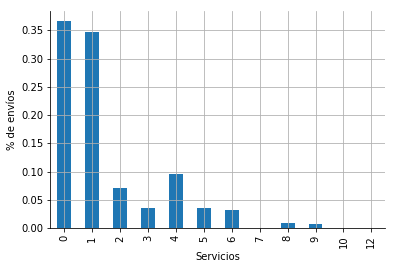

In [0]:
ax = df_train['service'].value_counts(normalize=True,sort=True,
                                       dropna=True).sort_index().plot(kind='bar',
                                                       grid=True)
ax.set(xlabel="Servicios",ylabel="% de envíos")
sns.despine()

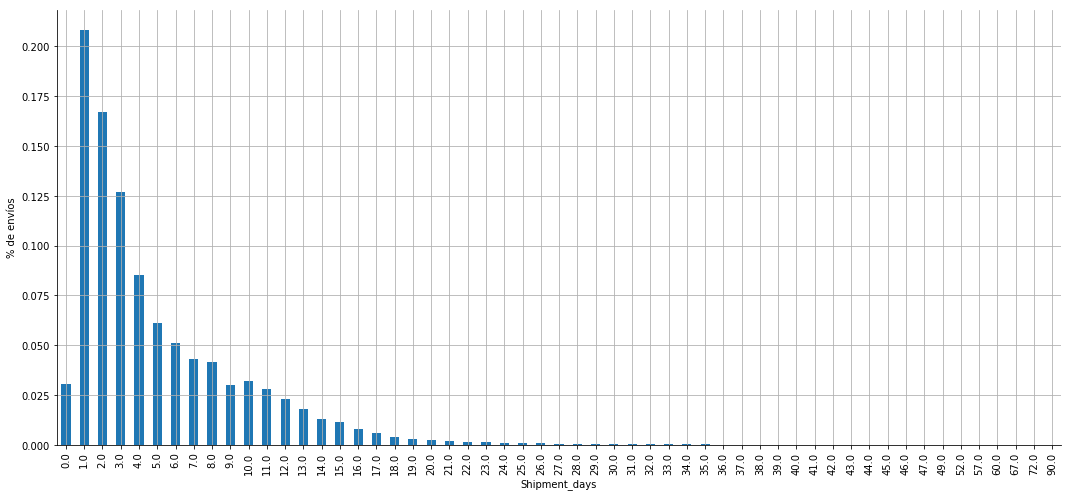

In [0]:
plt.figure(figsize=(18,8))
ax = df_train['shipment_days'].value_counts(normalize=True,sort=True,
                                       dropna=True).sort_index().plot(kind='bar',
                                                     grid=True)
ax.set(xlabel="Shipment_days",ylabel="% de envíos")
sns.despine()

El primer gráfico confirma la información devuelta por la función describe donde los tres servicios más frecuentes son el 0, el 1 y el 4.

En cuanto a shipment_days observamos que aquellos envíos que tardan 19 días o más representan un porcentaje muy mínimo del total de los datos (alrededor del 0.01%)

In [0]:
receiver_zc_train = df_train['receiver_zipcode'].astype('category')
receiver_zc_train.describe()

count     321523
unique     18244
top        36400
freq         349
Name: receiver_zipcode, dtype: int64

Observamos que el receiver_zipcode más frecuente es el 36400 el cual aparece 349 veces.

#### Análisis del conjunto de test

Realizamos ahora un análisis similar sobre el conjunto de validación (o test).

In [0]:
df_test.describe()

,sender_zipcode,receiver_zipcode,quantity,service,shipment_days
count,32524.000000,32524.000000,32524.000000,32524.000000,32524.000000
mean,7761.103831,22462.617575,1.285328,1.677254,1.599250
std,4848.277470,25891.507878,0.667577,2.412361,0.957553
min,1001.000000,1001.000000,1.000000,0.000000,0.000000
25%,3437.000000,5771.500000,1.000000,0.000000,1.000000
50%,6795.000000,13025.000000,1.000000,0.000000,1.000000
75%,13076.000000,25615.000000,1.000000,4.000000,2.000000
max,19970.000000,99950.000000,5.000000,10.000000,6.000000


In [0]:
df_test.describe(include='object')

,sender_state,receiver_state,shipment_type,status,date_created_only_date,date_visit_only_date
count,32524,32524,32524,32524,32524,32524
unique,1,27,3,2,8,6
top,SP,SP,express,done,2019-03-21,2019-03-28
freq,32524,22836,25096,32281,8908,10625


**Observaciones**

- Este conjunto cuenta con un total de 32525 envíos.
- El 50% de los envíos utiliza el servicio 0.
- La variable shipment_days abarca desde 1 día hasta 6 días.
- La mayoría de los envíos son de un item.
- Aproximadamente el 70% (22836) de estos envíos llegan a San Pablo.

Analizamos ahora las variables service, shipment_days y receiver_zipcode.

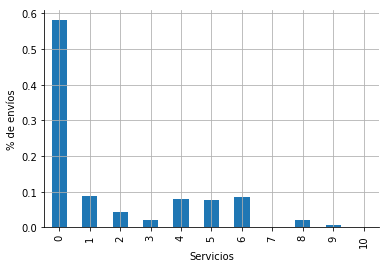

In [0]:
ax = df_test['service'].value_counts(normalize=True,sort=True,
                                       dropna=True).sort_index().plot(kind='bar',
                                                       grid=True)
ax.set(xlabel="Servicios",ylabel="% de envíos")
sns.despine()

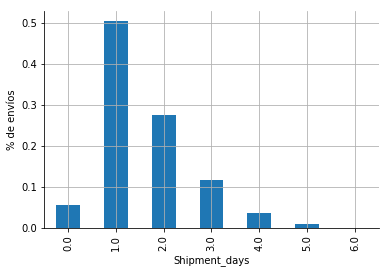

In [0]:
plt.figure(figsize=(6,4))
ax = df_test['shipment_days'].value_counts(normalize=True,sort=True,
                                       dropna=True).sort_index().plot(kind='bar',
                                                     grid=True)
ax.set(xlabel="Shipment_days",ylabel="% de envíos")
sns.despine()

In [0]:
receiver_zc_test = df_test['receiver_zipcode'].astype('category')
receiver_zc_test.describe()

count     32524
unique     9001
top       13470
freq         58
Name: receiver_zipcode, dtype: int64

El primer gráfico confirma el alto predominio del servicio de correo 0, el cual abarca más del 50% de los datos del conjunto de test.

En el caso de shipment_days, a diferencia del conjunto de entrenamiento, esta variable solo abarca 7 valores distintos donde predominan los envíos que tardan 1 o 2 en llegar.

En este caso, el zipcode 13470 es el más frecuente en todo el dataset el cual se presenta en 58 envíos.

Por lo tanto al momento de analizar los resultados debemos tener en cuenta las diferencias entre el conjunto de entrenamiento y de test principalmente lo que notamos en shipment_days (dado que este es nuestro target) y en service (pues es uno de los features más importantes en nuestro análisis).

#### Definición de X_train, y_train, X_test e y_test.

Ahora podemos definir los X_train, y_train , X_test, e y_test.

En X_train vamos a seleccionar los features que previamente habiamos elegimos como los mas representativos.

In [0]:
X_train = df_train[['receiver_zipcode','service']]

In [0]:
y_train = df_train[['shipment_days']]

In [0]:
X_test = df_test[['receiver_zipcode','service']]

In [0]:
y_test = df_test[['shipment_days']]

Corroboremos que todos nos quedaron del mismo tamaño:

In [0]:
X_train.shape

(321523, 2)

In [0]:
X_test.shape

(32524, 2)

In [0]:
y_train.shape

(321523, 1)

In [0]:
y_test.shape

(32524, 1)

### DecisionTree

Como nuestro y (shipment_days) es categórico consideramos mejor una clasificación.
Como primera elección consideramos decisiontree para ver como se comporta con la clasificación:

In [0]:
features_names = ["receiver_code","service"]

In [0]:
target_names = ["0","1","2","3","4","5","6"]

Para usar el clasificador desicionTree necesita que el target sea un valor entero, por ende convertimos shipment_day en entero (acá podemos ver el gráfico más arriba planteado de shipment_days):

In [0]:
shipment_days = y_train['shipment_days'].astype(int)
shipment_days_byclass = [None] * len(shipment_days)
for line,row in enumerate(shipment_days):
    if 0==row:
        shipment_days_byclass[line] = 0
    elif 1==row:
        shipment_days_byclass[line] = 1     
    elif 2==row:
        shipment_days_byclass[line] = 2
    elif 3==row:
        shipment_days_byclass[line] = 3
    elif 4==row:
        shipment_days_byclass[line] = 4
    elif 5==row:
        shipment_days_byclass[line] = 5        
    else:
        shipment_days_byclass[line] = 6

In [0]:
y_train['shipment_days_byclass'] = shipment_days_byclass

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
y_train['shipment_days_byclass'].head()

0    5
1    5
2    4
3    2
4    6
Name: shipment_days_byclass, dtype: int64

Hay que hacer lo mismo para los valores de validación:

In [0]:
shipment_days_test = y_test['shipment_days'].astype(int)
shipment_days_byclass_test = [None] * len(shipment_days_test)
for line,row in enumerate(shipment_days_test):
    if 0==row:
        shipment_days_byclass_test[line] = 0
    elif 1==row:
        shipment_days_byclass_test[line] = 1     
    elif 2==row:
        shipment_days_byclass_test[line] = 2
    elif 3==row:
        shipment_days_byclass_test[line] = 3
    elif 4==row:
        shipment_days_byclass_test[line] = 4
    elif 5==row:
        shipment_days_byclass_test[line] = 5        
    else:
        shipment_days_byclass_test[line] = 6

In [0]:
y_test['shipment_days_byclass'] = shipment_days_byclass_test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
y_test['shipment_days_byclass'].values

array([1, 0, 3, ..., 3, 1, 2])

In [0]:
X_train.head()

,receiver_zipcode,service
0,14500,1
1,58670,1
2,22723,2
3,18682,2
4,68908,1


In [0]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train["shipment_days_byclass"])

In [0]:
predictions = clf.predict(X_train)
print ('Accuracy: %d ' % ((np.sum(y_train["shipment_days_byclass"] == predictions))/float(y_train["shipment_days_byclass"].size)*100))

Accuracy: 65 


In [0]:
predictions = clf.predict(X_test)
print ('Accuracy: %d ' % ((np.sum(y_test["shipment_days_byclass"] == predictions))/float(y_test["shipment_days_byclass"].size)*100))

Accuracy: 50 


In [0]:
print("Reporte de clasificación (sobre conjunto de evaluación):", end="\n\n")
y_true, y_pred = y_test["shipment_days_byclass"], clf.predict(X_test)
print(classification_report(y_true, y_pred), end="\n\n")

Reporte de clasificación (sobre conjunto de evaluación):

              precision    recall  f1-score   support

           0       0.34      0.37      0.35      1826
           1       0.67      0.73      0.70     16445
           2       0.43      0.31      0.36      8988
           3       0.28      0.19      0.23      3774
           4       0.13      0.10      0.11      1195
           5       0.04      0.05      0.05       285
           6       0.00      0.18      0.00        11

    accuracy                           0.50     32524
   macro avg       0.27      0.28      0.26     32524
weighted avg       0.51      0.50      0.50     32524




Del reporte de clasificación podemos leer que las 4 primeras clases son las que mejor precisión tienen, y las demás muy poca prediccción tienen; cuarta, quinta y sexta. En sexta tenemos una precisión de un 0 porciento por ende no las está prediciendo. También esto lo podemos ver en la matriz de confusión que se muestra a continuación:

In [0]:
print(confusion_matrix(y_true, y_pred)) 

[[  667  1089    57     7     3     0     3]
 [ 1140 11990  2479   504   134    25   173]
 [  151  3968  2804  1148   291    92   534]
 [   12   670  1042   731   289   131   899]
 [    1   100   153   205   116    70   550]
 [    0    13    24    34    31    15   168]
 [    0     0     1     2     3     3     2]]


A continuación haremos una exploración de los hiperparámetros, para ver cuáles son los mejores hiperparámetros para el decisionTree que maximicen el accuracy.

In [0]:
for idx, criterion in enumerate(('gini','entropy'),start=1):
    exploring_params = {
        "max_depth" :  [20, 21, 22],
        "min_samples_leaf" : [2,3,4]
    }
    m = tree.DecisionTreeClassifier(criterion=criterion)
    model = GridSearchCV(m, exploring_params, cv=5, scoring='accuracy') 
    model.fit(X_train, y_train["shipment_days_byclass"])
    print("# Exploración de hiperparámetros para función criterion \"%s\"" % criterion, end="\n\n")
    
    print("Mejor conjunto de parámetros:")
    print(model.best_params_, end="\n\n")
    
    print("Puntajes de la grilla:", end="\n\n")
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    
    for mean, std, params in zip(means, stds, model.cv_results_['params']):
        print("Exactitud: %0.3f (+/-%0.03f) para los parámetros %r" % (mean, std ** 2, params))
    print()
    
    print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
    y_true, y_pred = y_test["shipment_days_byclass"], model.predict(X_test)
    print(classification_report(y_true, y_pred), end="\n\n")
    
    print("================================================", end="\n\n")
    print("Matriz de confusión (sobre conjunto de evaluación) para %s" % criterion)
    print(confusion_matrix(y_true, y_pred))                          
    
    print("================================================", end="\n\n")
    
    print("Reporte de clasificación para el mejor clasificador (sobre conjunto de entrenamiento):", end="\n\n")
    y_true_t, y_pred_t = y_train["shipment_days_byclass"], model.predict(X_train)
    print(classification_report(y_true_t, y_pred_t), end="\n\n")
    
    print("================================================", end="\n\n") 
    print("Matriz de confusión (sobre conjunto de entrenamiento) para %s" % criterion)
    print(confusion_matrix(y_true_t, y_pred_t))
    
    
    print("================================================", end="\n\n")    
    print ("Accuracy on test is ", accuracy_score(y_test["shipment_days_byclass"], y_pred)*100)
    print ("Accuracy on training is ", accuracy_score(y_train["shipment_days_byclass"], y_pred_t)*100)
    
    print("================================================", end="\n\n")    
  

# Exploración de hiperparámetros para función criterion "gini"

Mejor conjunto de parámetros:
{'max_depth': 20, 'min_samples_leaf': 4}

Puntajes de la grilla:

Exactitud: 0.549 (+/-0.000) para los parámetros {'max_depth': 20, 'min_samples_leaf': 2}
Exactitud: 0.551 (+/-0.000) para los parámetros {'max_depth': 20, 'min_samples_leaf': 3}
Exactitud: 0.552 (+/-0.000) para los parámetros {'max_depth': 20, 'min_samples_leaf': 4}
Exactitud: 0.547 (+/-0.000) para los parámetros {'max_depth': 21, 'min_samples_leaf': 2}
Exactitud: 0.549 (+/-0.000) para los parámetros {'max_depth': 21, 'min_samples_leaf': 3}
Exactitud: 0.551 (+/-0.000) para los parámetros {'max_depth': 21, 'min_samples_leaf': 4}
Exactitud: 0.545 (+/-0.000) para los parámetros {'max_depth': 22, 'min_samples_leaf': 2}
Exactitud: 0.548 (+/-0.000) para los parámetros {'max_depth': 22, 'min_samples_leaf': 3}
Exactitud: 0.549 (+/-0.000) para los parámetros {'max_depth': 22, 'min_samples_leaf': 4}

Reporte de clasificación para el mejor

De acuerdo a los accuraccy obtenidos entre las funciones "gini" y "entropy", nos estaría dando un mejor resultado para gini. Con los parámetros 'max_depth': 20, 'min_samples_leaf': 4, dónde min_samples_leaf es el número mínimo de muestra requerido para ser un nodo hoja. Y max_depth es la máxima profundidad del árbol, si  no se especifica los nodos serán expandidos hasta que las hojas sea puras, o hasta que todas las hojas contengan menos registros que min_samples_split.


Comparando los resultados sin hiperparámetros donde obteníamos 65. y 50. para los datos de entrenamiento y  validación, con los mejores obtenidos para gini con valores en 61 y 52 para entrenamiento y validación, podemos concluir que no obtuvimos una mejora significativa.

###Regresion Polinomial

Habiendo probado un modelo de clasificación, intentaremos usar un modelo de regresión y observar si los resultados entre ambos enfoques son comparables. Recordemos que en este caso el target es una variable numérica.

Consideramos los mismos conjuntos de entrenamiento y validación que los usados en Decisión Tree.

In [0]:
X_train.sample(5)

,receiver_zipcode,service
74119,87980,1
451549,3115,0
310031,89887,1
93752,5419,5
228057,35162,1


In [0]:
X_test.sample(5)

,receiver_zipcode,service
233210,9843,0
76365,3224,0
99394,14165,0
397905,91740,6
499856,18060,0


In [0]:
y_train['shipment_days'].sample(5)

78173      0.0
32153      1.0
158325    10.0
136870     0.0
434802     3.0
Name: shipment_days, dtype: float64

In [0]:
y_test['shipment_days'].sample(5)

380207    2.0
481375    1.0
157139    2.0
109915    1.0
323500    1.0
Name: shipment_days, dtype: float64

Vamos probar diferentes grados de polinomio (desde uno lineal hasta uno de grado 8) y compararemos la media del error cuadrático en cada uno de los conjuntos de entrenamiento y validación para determinar el mejor ajuste posible.

In [0]:
X_train_pol = X_train
X_test_pol = X_test
y_train_pol = y_train['shipment_days']
y_test_pol = y_test['shipment_days']

#### Regresión lineal

In [0]:
model = LinearRegression()
model.fit(X_train_pol, y_train_pol)

entrenamiento1 = mean_squared_error(y_train_pol, model.predict(X_train_pol))
validacion1 = mean_squared_error(y_test_pol, model.predict(X_test_pol))

print('Media del error cuadrado para entrenamiento: %.2f' % 
      entrenamiento1)
print('Media del error cuadrado para validación: %.2f' %
      validacion1)

Media del error cuadrado para entrenamiento: 16.15
Media del error cuadrado para validación: 7.63


#### Polinomio cuadrático

In [0]:
polynomial_degree = 2 

poly_features = PolynomialFeatures(polynomial_degree)
poly_features.fit(X_train_pol)

X_poly_train = poly_features.transform(X_train_pol)
X_poly_test = poly_features.transform(X_test_pol)

model = LinearRegression()
model.fit(X_poly_train, y_train_pol)

entrenamiento2= mean_squared_error(y_train_pol, model.predict(X_poly_train))
validacion2= mean_squared_error(y_test_pol, model.predict(X_poly_test))

print('Media del error cuadrado para entrenamiento: %.2f' % 
      entrenamiento2)
print('Media del error cuadrado para validación: %.2f' %
      validacion2)

Media del error cuadrado para entrenamiento: 14.20
Media del error cuadrado para validación: 6.37


#### Polinomio cúbico

In [0]:
polynomial_degree = 3 

poly_features = PolynomialFeatures(polynomial_degree)
poly_features.fit(X_train_pol)

X_poly_train = poly_features.transform(X_train_pol)
X_poly_test = poly_features.transform(X_test_pol)

model = LinearRegression()
model.fit(X_poly_train, y_train_pol)

entrenamiento3= mean_squared_error(y_train_pol, model.predict(X_poly_train))
validacion3= mean_squared_error(y_test_pol, model.predict(X_poly_test))

print('Media del error cuadrado para entrenamiento: %.2f' % 
      entrenamiento3)
print('Media del error cuadrado para validación: %.2f' %
      validacion3)

Media del error cuadrado para entrenamiento: 11.67
Media del error cuadrado para validación: 5.02


#### Polinomio de grado 4

In [0]:
polynomial_degree = 4 

poly_features = PolynomialFeatures(polynomial_degree)
poly_features.fit(X_train_pol)

X_poly_train = poly_features.transform(X_train_pol)
X_poly_test = poly_features.transform(X_test_pol)

model = LinearRegression()
model.fit(X_poly_train, y_train_pol)

entrenamiento4= mean_squared_error(y_train_pol, model.predict(X_poly_train))
validacion4= mean_squared_error(y_test_pol, model.predict(X_poly_test))

print('Media del error cuadrado para entrenamiento: %.2f' % 
      entrenamiento4)
print('Media del error cuadrado para validación: %.2f' %
      validacion4)

Media del error cuadrado para entrenamiento: 11.45
Media del error cuadrado para validación: 4.26


#### Polinomio de grado 5

In [0]:
polynomial_degree = 5

poly_features = PolynomialFeatures(polynomial_degree)
poly_features.fit(X_train_pol)

X_poly_train = poly_features.transform(X_train_pol)
X_poly_test = poly_features.transform(X_test_pol)

model = LinearRegression()
model.fit(X_poly_train, y_train_pol)

entrenamiento5= mean_squared_error(y_train_pol, model.predict(X_poly_train))
validacion5= mean_squared_error(y_test_pol, model.predict(X_poly_test))

print('Media del error cuadrado para entrenamiento: %.2f' % 
      entrenamiento5)
print('Media del error cuadrado para validación: %.2f' %
      validacion5)

Media del error cuadrado para entrenamiento: 12.07
Media del error cuadrado para validación: 4.67


#### Polinomio de grado 6

In [0]:
polynomial_degree = 6

poly_features = PolynomialFeatures(polynomial_degree)
poly_features.fit(X_train_pol)

X_poly_train = poly_features.transform(X_train_pol)
X_poly_test = poly_features.transform(X_test_pol)

model = LinearRegression()
model.fit(X_poly_train, y_train_pol)

entrenamiento6= mean_squared_error(y_train_pol, model.predict(X_poly_train))
validacion6= mean_squared_error(y_test_pol, model.predict(X_poly_test))

print('Media del error cuadrado para entrenamiento: %.2f' % 
      entrenamiento6)
print('Media del error cuadrado para validación: %.2f' %
      validacion6)

Media del error cuadrado para entrenamiento: 12.72
Media del error cuadrado para validación: 5.01


#### Polinomio de grado 7

In [0]:
polynomial_degree = 7

poly_features = PolynomialFeatures(polynomial_degree)
poly_features.fit(X_train_pol)

X_poly_train = poly_features.transform(X_train_pol)
X_poly_test = poly_features.transform(X_test_pol)

model = LinearRegression()
model.fit(X_poly_train, y_train_pol)

entrenamiento7= mean_squared_error(y_train_pol, model.predict(X_poly_train))
validacion7= mean_squared_error(y_test_pol, model.predict(X_poly_test))

print('Media del error cuadrado para entrenamiento: %.2f' % 
      entrenamiento7)
print('Media del error cuadrado para validación: %.2f' %
      validacion7)

Media del error cuadrado para entrenamiento: 13.69
Media del error cuadrado para validación: 5.82


#### Polinomio de grado 8

In [0]:
polynomial_degree = 8

poly_features = PolynomialFeatures(polynomial_degree)
poly_features.fit(X_train_pol)

X_poly_train = poly_features.transform(X_train_pol)
X_poly_test = poly_features.transform(X_test_pol)

model = LinearRegression()
model.fit(X_poly_train, y_train_pol)

entrenamiento8= mean_squared_error(y_train_pol, model.predict(X_poly_train))
validacion8= mean_squared_error(y_test_pol, model.predict(X_poly_test))

print('Media del error cuadrado para entrenamiento: %.2f' % 
      entrenamiento8)
print('Media del error cuadrado para validación: %.2f' %
      validacion8)

Media del error cuadrado para entrenamiento: 14.66
Media del error cuadrado para validación: 6.61


Realizamos una visualización con esta información para determinar cual es el polinomio que mejor puede aproximar nuestros datos.

In [0]:
x=[1,2,3,4,5,6,7,8] #grados del polinomio
y1=[entrenamiento1, entrenamiento2,entrenamiento3, entrenamiento4, entrenamiento5,
  entrenamiento6, entrenamiento7, entrenamiento8] #error en el conjunto de entrenamiento
y2=[validacion1,validacion2,validacion3,validacion4,validacion5,
   validacion6,validacion7,validacion8] #error en el conjunto de validación

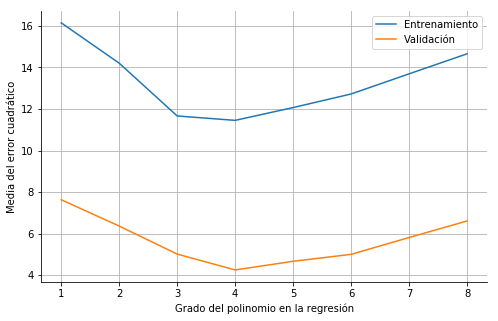

In [0]:
plt.figure(figsize=(8,5))

sns.lineplot(x, y1, label='Entrenamiento')
sns.lineplot(x, y2, label= 'Validación')

plt.ylabel('Media del error cuadrático')
plt.xlabel('Grado del polinomio en la regresión')
plt.grid()
sns.despine()

Observamos que el polinomio de grado 4 podría ser una buena elección puesto que observamos que para este valor el error cuadrático se minimiza (tanto en el conjunto de validación como en el entrenamiento).

**Visualización de los resultados de entrenamiento usando un solo feature**  

A continuación con el objetivo de mostrar una visualización del ajuste de los datos, vamos a seleccionar un solo feature (receiver_zipcode) para entrenar el modelo con una regresión polinomial de grado 4 (el mejor ajuste hasta el momento).

In [0]:
X_train_pol = np.array(X_train['receiver_zipcode']).reshape(-1,1)

In [0]:
X_test_pol = np.array (X_test['receiver_zipcode']).reshape(-1,1)

In [0]:
y_train_pol = np.array(y_train['shipment_days']).reshape(-1,1)

In [0]:
y_test_pol = np.array(y_test['shipment_days']).reshape(-1,1)

Verificamos los tamaños de los conjuntos.

In [0]:
X_train_pol.shape

(321523, 1)

In [0]:
y_train_pol.shape

(321523, 1)

In [0]:
X_test_pol.shape

(32524, 1)

In [0]:
y_test_pol.shape

(32524, 1)

In [0]:
polynomial_degree = 4

poly_features = PolynomialFeatures(polynomial_degree)
poly_features.fit(X_train_pol)

X_poly_train = poly_features.transform(X_train_pol)
X_poly_test = poly_features.transform(X_test_pol)

model = LinearRegression()
model.fit(X_poly_train, y_train_pol)

print('Media del error cuadrado para entrenamiento: %.2f' % 
      mean_squared_error(y_train_pol, model.predict(X_poly_train)))
print('Media del error cuadrado para validación: %.2f' %
      mean_squared_error(y_test_pol, model.predict(X_poly_test)))

Media del error cuadrado para entrenamiento: 15.08
Media del error cuadrado para validación: 6.48


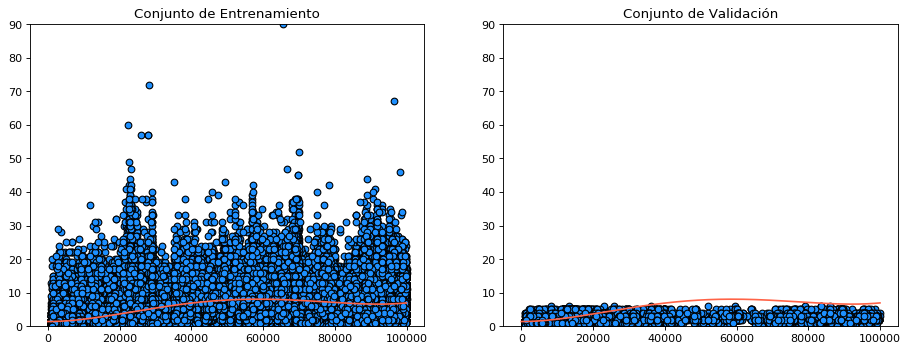

In [0]:
plt.figure(figsize=(14, 5), dpi=80, facecolor='w', edgecolor='k')

X_range_start = np.min(np.r_[X_train, X_test])
X_range_stop = np.max(np.r_[X_train, X_test])

y_range_start = np.min(np.r_[y_train, y_test])
y_range_stop = np.max(np.r_[y_train, y_test])

X_linspace = np.linspace(X_range_start, X_range_stop, 200).reshape(-1, 1)
X_linspace_poly = poly_features.transform(X_linspace)

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.scatter(X_train_pol, y_train_pol, facecolor="dodgerblue", edgecolor="k", label="datos")
plt.plot(X_linspace, model.predict(X_linspace_poly), color="tomato", label="modelo")
plt.ylim(y_range_start, y_range_stop)
plt.title("Conjunto de Entrenamiento")

# Conjunto de validación
plt.subplot(1, 2, 2)
plt.scatter(X_test_pol, y_test_pol, facecolor="dodgerblue", edgecolor="k", label="datos")
plt.plot(X_linspace, model.predict(X_linspace_poly), color="tomato", label="modelo")
plt.ylim(y_range_start, y_range_stop)
plt.title("Conjunto de Validación")

plt.show()

De acuerdo a los resultados anteriores los errores sobre el conjunto de entrenamiento y validación son bastante altos. Esto también se evidencia en las visualizaciones donde la regresión polinomial no proporciona un buen ajuste de los datos. Sin embargo, dado que el conjunto de validación tiene muchos menos puntos resulta normal que la regresión en este caso tenga un error menor.




###Conclusiones

Durante este práctico se intentó predecir el valor de la variable shipment_days mediante dos enfoques distintos: un modelo de clasificación y uno de regresión.

En el caso del modelo de clasificación se utilizaron 6 clases tratando de cubrir de manera equitativa las distribuciones en el conjunto de entrenamiento y en el de validación. Se utilizó un modelo de árbol de decisión simple y otro con búsqueda de hiperparamétros. En ambos casos se obtuvieron buenas predicciones en las clases mayoritarias.   


En el caso de la regresión se probaron diferentes grados de polinomio y se comparó la media del error cuadrático tanto en el conjunto de entrenamiento como en el de validación. De estos resultados pudimos observar que con un polinomio de grado 4 obteniamos un valor menor en el error, que aunque no era demasiado pequeño tampoco era demasiado grande.

Consideramos que si bien los resultados en ambos enfoques podrían ser mejorables son  bastante aceptables considerando el hecho de que estamos trabajando con una muestra pequeña de información.

También se logró una definición de los datasets, que para nuestra problemática era necesario. 
